<a href="https://colab.research.google.com/github/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/df-filtering/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install libspatialindex-dev

In [ ]:
!wget https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/accident.py?raw=true
!mv accident.py\?raw\=true accident.py

In [ ]:
pip install osmnx

In [1]:
import osmnx as ox
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from accident import ACCIDENT

In [89]:
G = ox.graph_from_place('Toronto, Ontario, Canada', network_type='drive')

In [ ]:
#G = ox.consolidate_intersections(ox.project_graph(G), tolerance=30, rebuild_graph=True)

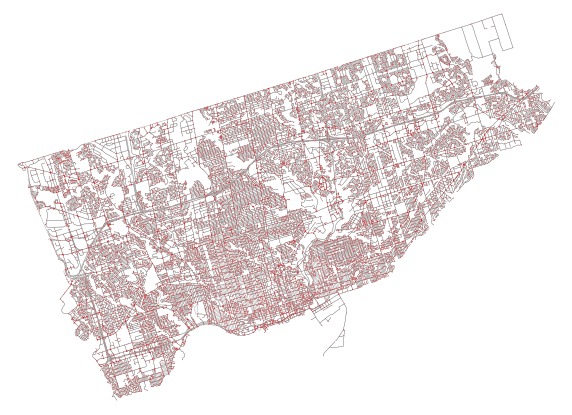

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

In [ ]:
ox.plot_graph(G, bgcolor='white', node_size=0.3, node_color="red", edge_linewidth=0.4, edge_alpha=1, dpi=300, figsize=(10,10))

In [ ]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 27460
Number of edges: 73230
Average in degree:   2.6668
Average out degree:   2.6668


In [119]:
edges =  list(G.edges.data())
edges[52][2]

{'geometry': <shapely.geometry.linestring.LineString at 0x7fd3dfc08518>,
 'highway': 'motorway',
 'lanes': '5',
 'length': 334.943,
 'maxspeed': '100',
 'name': 'Highway 401 Collectors',
 'oneway': True,
 'osmid': 4071678,
 'ref': '401'}

In [99]:
nodes =  list(G.nodes.data())
nodes[1]

(1497798, {'osmid': 1497798, 'x': -79.3355379, 'y': 43.7580721})

## KSI Dataset:

In [3]:
ksi_df = gpd.read_file("https://opendata.arcgis.com/datasets/cc17cc27ee5a4989b78d9a3810c6c007_0.geojson")

In [ ]:
ksi_df.head()

In [5]:
def assign_injury_index(injury:str):
  if injury == "Minimal":
    return 0.4
  elif injury == "Minor":
    return 0.6
  elif injury == "Major":
    return 0.8
  elif injury == "Fatal":
    return 1.0
  else:
    return 0.2

In [6]:
ksi_df["INJ_INDEX"] = ksi_df["INJURY"].apply(lambda x: assign_injury_index(x))

In [7]:
index_df = ksi_df[["ACCNUM", "INJ_INDEX"]].groupby(by="ACCNUM").sum()

Combining Date and Hour to have one single column:

In [ ]:
# ksi_df["DATE"] = pd.to_datetime(ksi_df['DATE']).dt.floor("D") + pd.to_timedelta(ksi_df["HOUR"], unit="hour")

Add datapoints to keep here:

In [8]:
cols_to_keep = ["LATITUDE", "LONGITUDE", "ACCNUM", "TIME", "VISIBILITY", "LIGHT",	"RDSFCOND"]
ksi_df = ksi_df[cols_to_keep]

Counting fatalities using duplicate rows:

In [9]:
fatalities = ksi_df["ACCNUM"].value_counts()
ksi_df["FATALITIES"] = ksi_df["ACCNUM"].apply(lambda x : fatalities[x])

In [10]:
ksi_df = ksi_df.drop_duplicates()
ksi_df.reset_index(drop=True, inplace=True)

In [11]:
ksi_df["G_NODE"]= ox.get_nearest_nodes(G, ksi_df["LONGITUDE"], ksi_df["LATITUDE"], method="balltree")
ksi_df.drop(["LATITUDE", "LONGITUDE"], axis=1, inplace=True)

In [12]:
ksi_df = ksi_df.merge(index_df, on="ACCNUM")

In [13]:
ksi_df = ksi_df.infer_objects()
ksi_df

,ACCNUM,TIME,VISIBILITY,LIGHT,RDSFCOND,FATALITIES,G_NODE,INJ_INDEX
0,893184,236,Clear,Dark,Wet,8,33771082,4.2
1,909646,315,Snow,"Dark, artificial",Slush,5,158754118,2.4
2,884090,705,Other,"Dark, artificial",Wet,2,21631723,1.0
3,885782,1940,Rain,Dark,Wet,2,26007459,1.0
4,882079,2210,Clear,"Dark, artificial",Dry,2,259750208,1.0
...,...,...,...,...,...,...,...,...
5685,9002468442,657,Clear,Dawn,Wet,2,86186677,1.0
5686,9002471073,1415,Clear,Daylight,Dry,3,287946845,1.8
5687,9002481518,850,Clear,Daylight,Wet,2,1498033,1.0
5688,9002496688,2324,Clear,"Dark, artificial",Dry,2,392516842,1.0


Creating column of accident objects:

In [14]:
ksi_df["ACCIDENT"] = ksi_df.apply(lambda x: ACCIDENT(x["ACCNUM"], x["TIME"], x["VISIBILITY"], x["LIGHT"], x["RDSFCOND"], x["FATALITIES"], x["INJ_INDEX"]), axis=1)

In [15]:
ksi_df

,ACCNUM,TIME,VISIBILITY,LIGHT,RDSFCOND,FATALITIES,G_NODE,INJ_INDEX,ACCIDENT
0,893184,236,Clear,Dark,Wet,8,33771082,4.2,"ACCIDENT(acc_id='893184', date='236', visibili..."
1,909646,315,Snow,"Dark, artificial",Slush,5,158754118,2.4,"ACCIDENT(acc_id='909646', date='315', visibili..."
2,884090,705,Other,"Dark, artificial",Wet,2,21631723,1.0,"ACCIDENT(acc_id='884090', date='705', visibili..."
3,885782,1940,Rain,Dark,Wet,2,26007459,1.0,"ACCIDENT(acc_id='885782', date='1940', visibil..."
4,882079,2210,Clear,"Dark, artificial",Dry,2,259750208,1.0,"ACCIDENT(acc_id='882079', date='2210', visibil..."
...,...,...,...,...,...,...,...,...,...
5685,9002468442,657,Clear,Dawn,Wet,2,86186677,1.0,"ACCIDENT(acc_id='9002468442', date='657', visi..."
5686,9002471073,1415,Clear,Daylight,Dry,3,287946845,1.8,"ACCIDENT(acc_id='9002471073', date='1415', vis..."
5687,9002481518,850,Clear,Daylight,Wet,2,1498033,1.0,"ACCIDENT(acc_id='9002481518', date='850', visi..."
5688,9002496688,2324,Clear,"Dark, artificial",Dry,2,392516842,1.0,"ACCIDENT(acc_id='9002496688', date='2324', vis..."


## Dataset Filtering

VISIBILITY:

In [16]:
notclear_df = ksi_df.loc[~ksi_df.VISIBILITY.isin(["Clear"])]

In [17]:
clear_df = ksi_df.loc[ksi_df.VISIBILITY.isin(["Clear"])]

RDSFCOND:

In [18]:
dry_road_df = ksi_df.loc[ksi_df.RDSFCOND.isin(["Dry"])]

In [19]:
wet_road_df = ksi_df.loc[ksi_df.RDSFCOND.isin(["Wet"])]

In [20]:
other_road_df = ksi_df.loc[~ksi_df.RDSFCOND.isin(["Dry", "Wet"])]

Time of Day:

In [21]:
ksi_df.TIME = pd.to_numeric(ksi_df.TIME, errors='coerce')
rush_hour_df = ksi_df.loc[(ksi_df.TIME.between(630,930, inclusive=True)) | (ksi_df.TIME.between(1500,1900, inclusive=True))]

In [22]:
day_time_df = ksi_df.loc[ksi_df.TIME.between(701,1900, inclusive=True)]

In [23]:
night_time_df = ksi_df.loc[ksi_df.TIME.between(1901,700, inclusive=True)]

## Processing a given Dataset

Set the Dataset to work on:

In [24]:
given_df = rush_hour_df

Collapsing dataset to get list of accidents for each node:

In [25]:
given_df = given_df.groupby('G_NODE')['ACCIDENT'].apply(list).reset_index(name='ACCIDENTS')

In [26]:
given_df

,G_NODE,ACCIDENTS
0,1497983,"[ACCIDENT(acc_id='7000804511', date='1630', vi..."
1,1498018,"[ACCIDENT(acc_id='6001623474', date='1830', vi..."
2,1498033,"[ACCIDENT(acc_id='9002481518', date='850', vis..."
3,1498128,"[ACCIDENT(acc_id='3001877674', date='837', vis..."
4,3458707,"[ACCIDENT(acc_id='9000402520', date='1755', vi..."
...,...,...
1763,7450278104,"[ACCIDENT(acc_id='1328002', date='1900', visib..."
1764,7606751368,"[ACCIDENT(acc_id='940240', date='1821', visibi..."
1765,7870612852,"[ACCIDENT(acc_id='987506', date='1605', visibi..."
1766,8043199175,"[ACCIDENT(acc_id='6002100980', date='1807', vi..."


Converting dataset to dict to set node attributes:

In [27]:
attr = given_df.set_index('G_NODE')['ACCIDENTS'].to_dict()

In [28]:
nx.set_node_attributes(G, [], "accident_list")
nx.set_node_attributes(G, attr, "accident_list")

Example Nodes:

In [88]:
G.nodes[1497983]

{'accident_list': [ACCIDENT(acc_id='7000804511', date='1630', visibility='Clear', light='Daylight', road_conditions='Dry', fatalities=2, inj_index=1.4)],
 'osmid': 1497983,
 'x': -79.3472824,
 'y': 43.7521302}

In [87]:
G.nodes[158754118]

{'accident_list': [], 'osmid': 158754118, 'x': -79.3162254, 'y': 43.6849494}

In [29]:
#check if node has an accident list if so
#go through each edge on the node if the edge is connecting to a node that also has an injury index then
#add its length to the cumulative length
#W base = no of accidents * avg inj_index for each accident on the node
#distribute weight to edges as follows, total length/edge length * Wbase

def getEdgeWeights(df):
  #dictionary of edge tuples to weight
  weights = {}

  sumGraphWeights = 0 #used to get the sum of all injury indexes in the 
  sumGraphNodes = 0
  #loop through each node
  for node in df['G_NODE']:
    #if G.nodes[node]['accident_list'] !=[]:
    totalLen = 0     
    totalWeight = 0    
    sumGraphNodes += 1
    for edge in nx.edges(G, node):
      totalLen += G.get_edge_data(edge[0], edge[1])[0]['length']
    for x in G.nodes[node]['accident_list']:
      totalWeight += x.inj_index
      sumGraphWeights += x.inj_index
    baseWeight = totalWeight/len(G.nodes[node]['accident_list'])
    for edge in nx.edges(G, node):
      weights[(edge[0], edge[1], 0)] = (totalLen/G.get_edge_data(edge[0], edge[1])[0]['length']) * baseWeight
  
  avgWeight = sumGraphWeights/sumGraphNodes
  
  for node in G.nodes:
    if G.nodes[node]['accident_list'] == []:
      totalLen = 0
      totalWeight = 0
      for edge in nx.edges(G, node):
        totalLen += G.get_edge_data(edge[0], edge[1])[0]['length']
      for edge in nx.edges(G, node):
        weights[(edge[0], edge[1], 0)] = (totalLen/G.get_edge_data(edge[0], edge[1])[0]['length']) *avgWeight

  return weights


In [ ]:
weights = getEdgeWeights(given_df)
nx.set_edge_attributes(G, 0, 'w')
nx.set_edge_attributes(G, weights, 'w')
nx.get_edge_attributes(G, 'w')

In [39]:
edges =  list(G.edges.data())
edges[999]

(21098690,
 4178866020,
 {'highway': 'tertiary',
  'lanes': '4',
  'length': 9.08,
  'maxspeed': '40',
  'name': 'Park Lawn Road',
  'oneway': False,
  'osmid': 417323680,
  'speed_kph': 40.0,
  'travel_time': 0.8,
  'w': 13.434067402376051})

## PageRank

In [31]:
def pagerank_top_50(G):
  pr = nx.pagerank_scipy(G, weight='w')
  pr = pd.DataFrame.from_dict(pr, orient='index').sort_values(by=0, ascending=False).rename(columns={0:"PageRank Score"})
  return pr.iloc[:50]

In [ ]:
top_50 = pagerank_top_50(G)
top_50

In [ ]:
top_50_nodes = list(top_50.index.values)

## Routing

In [123]:
# add speed on all edges missing data
G = ox.add_edge_speeds(G)
# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [134]:
def print_route_time_distance(route):
  route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))
  route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')))
  print('Route is', route_length, 'meters and takes', route_time, 'seconds.')


Get the safest route using Dijkstra's algorithm

In [125]:
def get_route_by_risk(origin, destination):
  return nx.shortest_path(G, source=origin, target = destination, weight = 'w', method='dijkstra')

def get_route_by_length(origin, destination):
  return nx.shortest_path(G, source=origin, target = destination, weight = 'length', method='dijkstra')

def get_route_by_time(origin, destination):
  return nx.shortest_path(G, source=origin, target = destination, weight = 'travel_time', method='dijkstra')


Plotting the route

In [126]:
def plot_route(route_list, color):
  ox.plot_graph_route(G, bgcolor='white', node_size=1.0, node_color='gray', edge_color='gray',route=route_list, route_color = color, dpi=300, figsize=(20,20))

In [127]:
orig = list(G)[1]
dest = list(G)[-1]
route_time = get_route_by_time(orig, dest)
route_distance = get_route_by_length(orig, dest)
route_risk = get_route_by_risk(orig, dest)

In [135]:
#Printing route's time and distance
print("Quickest route")
print_route_time_distance(route_time)
print("Shortest route")
print_route_time_distance(route_distance)
print("Least accident prone route")
print_route_time_distance(route_risk)

Quickest route
Route is 38636 meters and takes 1575 seconds.
Shortest route
Route is 33225 meters and takes 1907 seconds.
Least accident prone route
Route is 38602 meters and takes 1587 seconds.


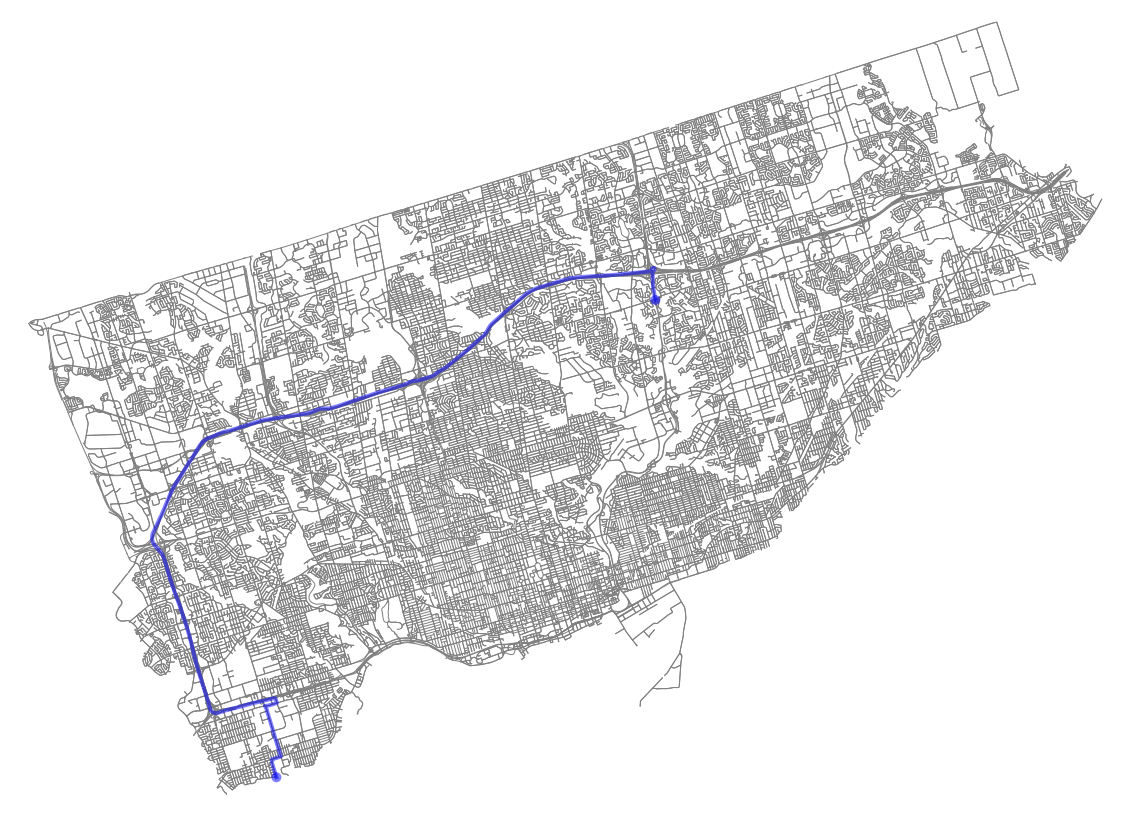

In [82]:
plot_route(route_time, 'b')

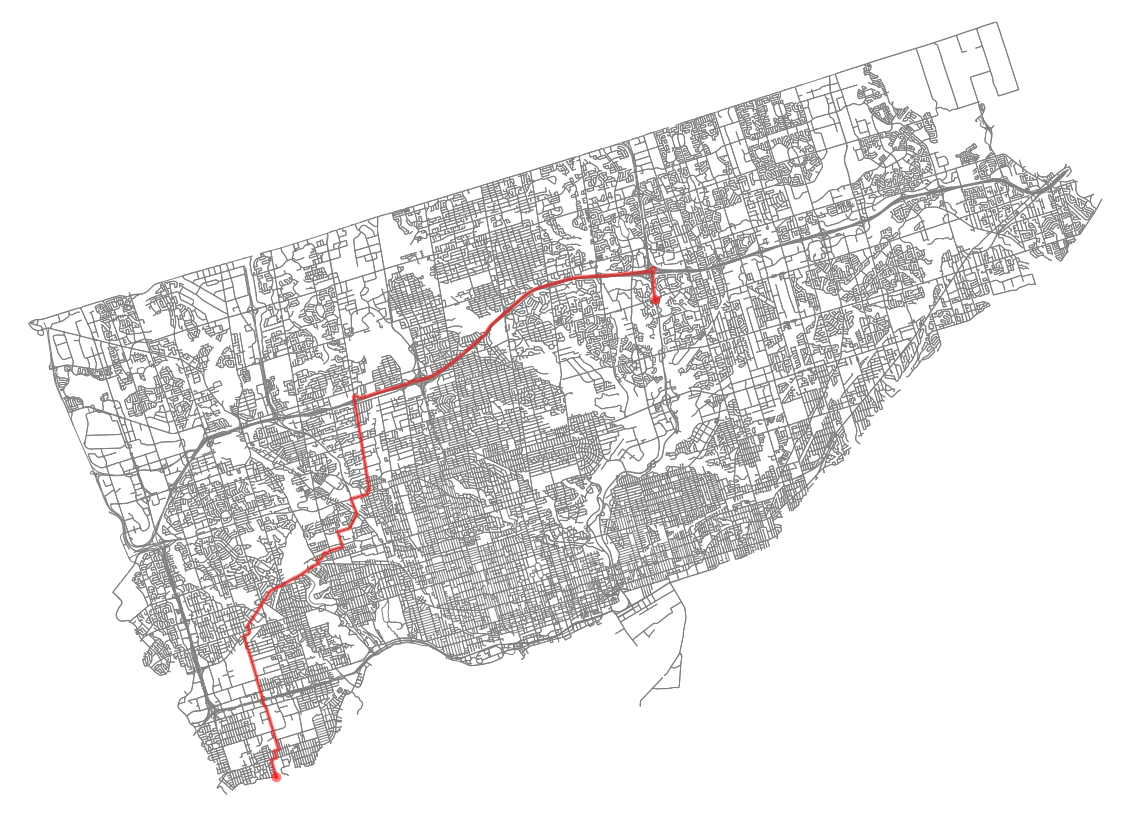

In [83]:
plot_route(route_distance, 'r')

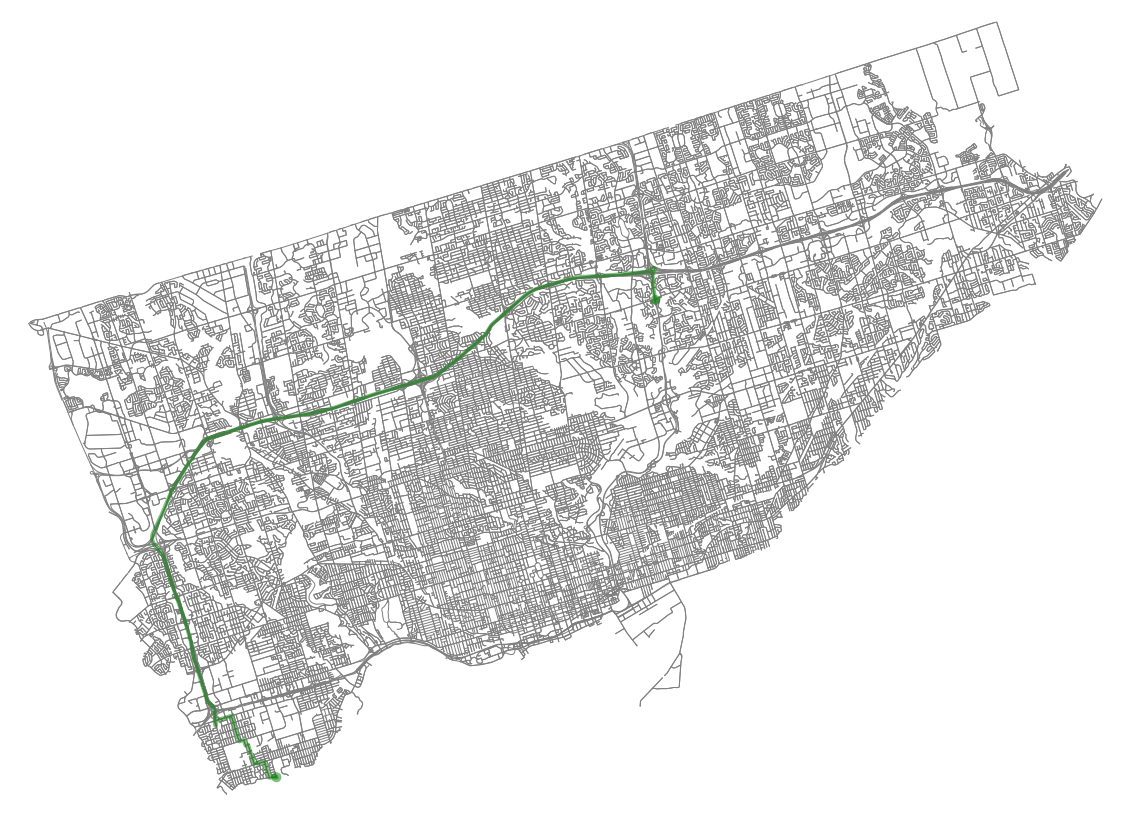

In [84]:
plot_route(route_risk, 'g')

## Clustering

In [ ]:
def most_central_edge(net):
    centrality = nx.edge_betweenness_centrality(net, k = 25)
    return max(centrality, key=centrality.get)

In [ ]:
gn = girvan_newman(G, most_valuable_edge=most_central_edge)
limited = itertools.takewhile(lambda c: len(c) <= 100, gn)

In [ ]:
communities = None
for communities in limited:
    pass
community_tuple = tuple(c for c in communities)

In [ ]:
cc1 = community_tuple[0]
cc2 = community_tuple[1]
cc3 = community_tuple[2]
cc4 = community_tuple[3]

## Printing Graphs

In [46]:
# nc = ['red' if node in cc else 'gray' for node in G.nodes()]
# ec = ['red' if (edge[0] in cc) or (edge[1] in cc) else 'gray' for edge in G.edges()]
ec = []
for edge in G.edges():
  if (edge[0] in cc1) or (edge[1] in cc1):
    ec.append('red')
  elif (edge[0] in cc2) or (edge[1] in cc2):
    ec.append('blue')
  elif (edge[0] in cc3) or (edge[1] in cc3):
    ec.append('green')
  elif (edge[0] in cc4) or (edge[1] in cc4):
    ec.append('orange')
  else:
    ec.append("gray")

NameError: ignored

KeyboardInterrupt: ignored

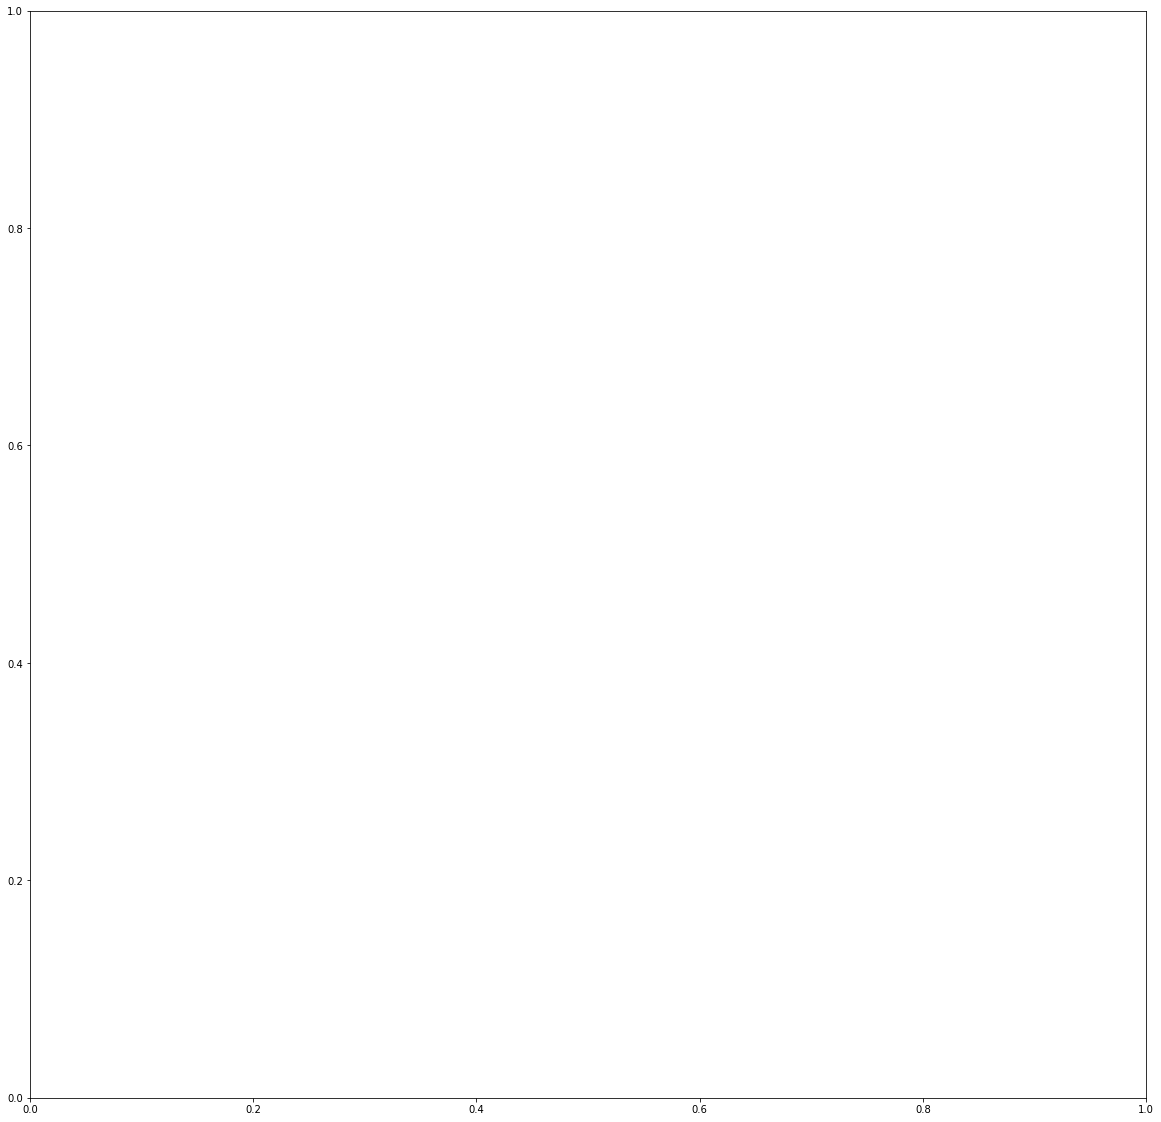

In [47]:
ox.plot_graph(G, bgcolor='white', node_size=1.0, node_color='gray', edge_color=ec, edge_linewidth=1.0, edge_alpha=1, dpi=300, figsize=(20,20))